In [ ]:
#!pip install torch_geometric

In [3]:
import torch
import torch.nn.functional as F
import torch_geometric

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
# Random generation of mixtures with M1 components

MU_MAX = 10
S_MAX = 1
mu_ranges = [-MU_MAX, MU_MAX]
std_ranges = [0.001, S_MAX]

M1 = 6   # mixture components in input
M2 = 3   # mixture components in output

#sampling M1 random weights
pis = F.softmax(torch.rand(M1))
print(torch.sum(pis))

#sampling of M1 random means
mus = mu_ranges[0]+torch.rand(M1)*(mu_ranges[1]-mu_ranges[0])
#sampling of M1 random stds
stds = std_ranges[0]+torch.rand(M1)*(std_ranges[1]-std_ranges[0])


tensor(1.0000)


<ipython-input-9-b0a916331a40>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pis = F.softmax(torch.rand(M1))


<ipython-input-11-3a11948c015a>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples, hist=False, kde_kws={"fill": False})


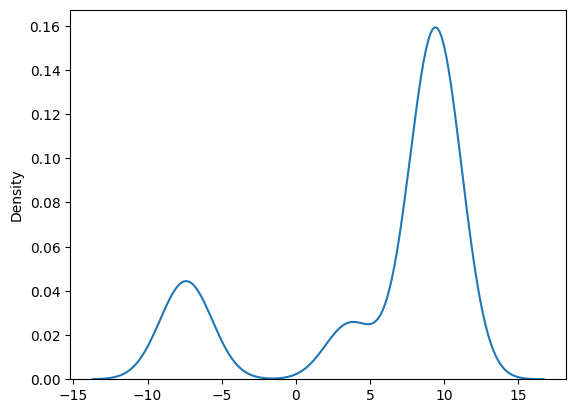

In [ ]:
# Plotting
samples = []
n = 1000 # nb of samples
for i in range(n):  # iteratively draw samples
    Z = np.random.choice(np.arange(M1), p=pis.numpy())

    samples.append(np.random.normal(mus[Z], stds[Z], 1))
sns.distplot(samples, hist=False, kde_kws={"fill": False})
plt.show()

In [ ]:
# Generate training set
Ntrain = 1000

PI = torch.empty((Ntrain, M1))
MU = torch.empty((Ntrain, M1))
SIGMA = torch.empty((Ntrain, M1))

for i in range(Ntrain):
  #sampling M1 random weights
  PI[i] = F.softmax(torch.rand(M1))

  #sampling of M1 random means
  MU[i] = mu_ranges[0]+torch.rand(M1)*(mu_ranges[1]-mu_ranges[0])
  #sampling of M1 random stds
  SIGMA[i] = std_ranges[0]+torch.rand(M1)*(std_ranges[1]-std_ranges[0])


<ipython-input-12-c2fe35e04f0d>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  PI[i] = F.softmax(torch.rand(M1))


In [ ]:
# Generate test set
Ntest = 10

PI_test = torch.empty((Ntest, M1))
MU_test = torch.empty((Ntest, M1))
SIGMA_test = torch.empty((Ntest, M1))

for i in range(Ntest):
  #sampling M1 random weights
  PI_test[i] = F.softmax(torch.rand(M1))

  #sampling of M1 random means
  MU_test[i] = mu_ranges[0]+torch.rand(M1)*(mu_ranges[1]-mu_ranges[0])
  #sampling of M1 random stds
  SIGMA_test[i] = std_ranges[0]+torch.rand(M1)*(std_ranges[1]-std_ranges[0])


<ipython-input-13-764cbc34b254>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  PI_test[i] = F.softmax(torch.rand(M1))


In [ ]:
from torch_geometric.data import Data
import torch_geometric.data as geom_data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, to_hetero, GATConv, GATv2Conv, MLP, GCNConv, global_mean_pool
import torch_geometric.transforms as T
import torch.optim as optim

In [ ]:
def comb(L):
    c = []
    for i in L:
        for j in L:
            if i != j:
              c.append([i,j])
    return torch.LongTensor(c)


In [ ]:
Ed = comb(np.arange(M1)).T # [2, num_edges]

Ed.dtype

torch.int64

In [ ]:
from torch_geometric.data import DataLoader, Data, Dataset

class MyDataset(Dataset):
    def __init__(self,N,PI,MU,SIGMA):
        super(MyDataset, self).__init__()
        graphs = []

        for j in range(N):
          data = Data()

          data.x = torch.vstack((PI[j],MU[j],SIGMA[j])).T # shape [M1,3]

          data.edge_index = comb(np.arange(M1)).T

          data.batch = j*torch.ones(M1, dtype=torch.long)

          graphs.append(data)
        self.data_list = graphs


    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

# Define a dataset
dataset = MyDataset(Ntrain, PI, MU, SIGMA)

In [ ]:
test_dataset = MyDataset(Ntest, PI_test, MU_test, SIGMA_test)

In [ ]:
BATCH_SIZE=64
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, follow_batch=['x', 'edge_index','batch'])

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
d = next(iter(loader))
d.x

tensor([[ 0.1168, -3.2748,  0.5450],
        [ 0.2139,  3.0176,  0.5570],
        [ 0.2418, -9.7375,  0.3224],
        ...,
        [ 0.1281,  6.3519,  0.9711],
        [ 0.1917,  7.6708,  0.9244],
        [ 0.1251, -9.8466,  0.9643]])

In [ ]:

class GraphNetwork(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, out_nodes):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2*hidden_channels)

        self.gat1 = GATConv(hidden_channels, hidden_channels, add_self_loops=False)
        self.gat2 = GATConv(2*hidden_channels, 2*hidden_channels, add_self_loops=False)

        self.lin1 = torch.nn.Linear(2*hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, out_channels*out_nodes)
        self.out_nodes = out_nodes
        self.out_channels = out_channels

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        #x, edge_index, x_batch, edge_index_batch = data.x, data.edge_index, data.x_batch, data.edge_index_batch
        # x: Node feature matrix of shape [batch, num_nodes, in_channels]
        # edge_index: Graph connectivity matrix of shape [2, num_edges, batch]

        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.gat1(x, edge_index).relu()
        #print('1: ', x)
        x = self.conv2(x, edge_index)
        x = self.gat2(x, edge_index).relu()
        #print('2: ', x)
        x = global_mean_pool(x, data.batch)
        #print('3: ', x)
        x = self.lin1(x).relu()
        x = self.lin2(x)
        #print('4: ', x)
        x = x.view(-1, self.out_nodes, self.out_channels)

        a = F.softmax(x[:,:,0:1],dim=1)
        b = MU_MAX*torch.tanh(x[:,:,1:2])
        c = S_MAX*torch.sigmoid(x[:,:,2:])
        xout = torch.cat((a, b, c), dim=2)
        return xout



In [ ]:
model = GraphNetwork(3, 16, 3, M2)


In [ ]:
newd = next(iter(loader))
out = model(newd)

In [ ]:
in_pi = F.softmax(d.x[:M1,0],dim=0).detach().numpy()
in_mu = d.x[:M1,1].detach().numpy()
in_sigma = d.x[:M1,2].detach().numpy()

out_pi = F.softmax(out[0,:,0],dim=0).detach().numpy()
out_mu = out[0,:,1].detach().numpy()
out_sigma = out[0,:,2].relu().detach().numpy()

<ipython-input-25-6f087d73a327>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(in_samples, hist=False, kde_kws={"fill": False}, label='in')
<ipython-input-25-6f087d73a327>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(out_samples, hist=False, kde_kws={"fill": False}, labe

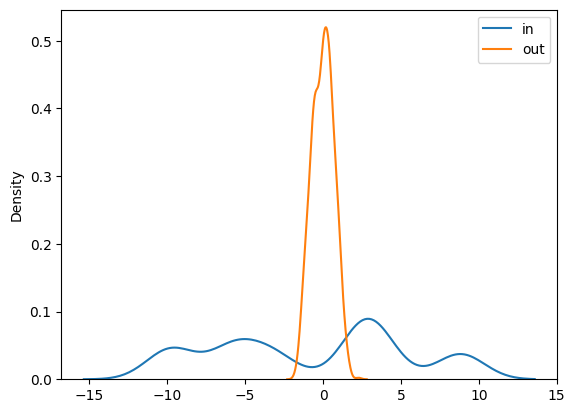

In [ ]:
in_samples = []
out_samples = []
n = 1000 # nb of samples
for i in range(n):  # iteratively draw samples
    Zin = np.random.choice(np.arange(M1), p=in_pi)
    Zout = np.random.choice(np.arange(M2), p=out_pi)
    in_samples.append(np.random.normal(in_mu[Zin], in_sigma[Zin], 1))
    out_samples.append(np.random.normal(out_mu[Zout], out_sigma[Zout], 1))
sns.distplot(in_samples, hist=False, kde_kws={"fill": False}, label='in')
sns.distplot(out_samples, hist=False, kde_kws={"fill": False}, label='out')
plt.legend()
plt.show()

In [ ]:
# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = GraphNetwork(3, 16, 3, M2).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
def gauss_kl(mu_1, sigma_1, mu_2, sigma_2):
  # kl div between two univariate gaussians
  return (((mu_2 - mu_1)**2+sigma_1**2)/(sigma_2**2)-2*(torch.log(sigma_1)-torch.log(sigma_2))-1) / 2


In [ ]:
def approx_kl(input_dist, output_dist):
  # input_dist: [B, M1, 3]
  # output_dist: [B, M2, 3]
  # variational approximation of the KL loss
  batch_size, input_comp, _ = input_dist.shape
  output_comp = output_dist.shape[1]
  eps = 10**(-10)
  loss = 0
  for b in range(batch_size):
      for i in range(input_comp):
          num = 0
          den = 0
          for j1 in range(input_comp):
              kl1 = gauss_kl(input_dist[b,i,1], input_dist[b,i,2],input_dist[b,j1,1], input_dist[b,j1,2])
              #print('kl1 = ', kl1)
              A = input_dist[b,j1,0]*torch.exp(-kl1)
              #print('A = ', A)
              num += A

          for j2 in range(output_comp):
              kl2 = gauss_kl(input_dist[b,i,1], input_dist[b,i,2],output_dist[b,j2,1], output_dist[b,j2,2])
              #print('kl2 = ', kl2)
              B = output_dist[b,j2,0]*torch.exp(-kl2)
              #print('B = ', B)
              den += B
          #print('num/den = ', num/den)
          #print('log(num/den) = ', torch.log(num+eps)-torch.log(den+eps))


          tmp_loss = input_dist[b,i,0]*(torch.log(num+eps)-torch.log(den+eps))
      #print('tmp loss = ', tmp_loss)
      loss += tmp_loss

  return loss





In [ ]:
# Training loop
def train():
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)

        optimizer.zero_grad()
        #print('IN = ', data.x)
        out = model(data)
        #print('out = ', out)
        inp = data.x.view(-1,M1,3)
        loss = approx_kl(inp, out)
        #print('loss = ', loss.item())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader.dataset)

# Run the training
for epoch in range(100):  # Run for 20 epochs
    tloss = train()
    print(f'Epoch {epoch+1}, Loss: {tloss:.4f}')

Epoch 1, Loss: 2.2814
Epoch 2, Loss: 1.8593
Epoch 3, Loss: 1.3462
Epoch 4, Loss: 1.0909
Epoch 5, Loss: 0.9468
Epoch 6, Loss: 0.8151
Epoch 7, Loss: 0.7054
Epoch 8, Loss: 0.6233
Epoch 9, Loss: 0.5603
Epoch 10, Loss: 0.5099
Epoch 11, Loss: 0.4681
Epoch 12, Loss: 0.4326
Epoch 13, Loss: 0.4034
Epoch 14, Loss: 0.3798
Epoch 15, Loss: 0.3619
Epoch 16, Loss: 0.3469
Epoch 17, Loss: 0.3352
Epoch 18, Loss: 0.3270
Epoch 19, Loss: 0.3191
Epoch 20, Loss: 0.3123
Epoch 21, Loss: 0.3068
Epoch 22, Loss: 0.3088
Epoch 23, Loss: 0.2992
Epoch 24, Loss: 0.3016
Epoch 25, Loss: 0.2986
Epoch 26, Loss: 0.2988
Epoch 27, Loss: 0.2956
Epoch 28, Loss: 0.2904
Epoch 29, Loss: 0.2918
Epoch 30, Loss: 0.2918
Epoch 31, Loss: 0.2888
Epoch 32, Loss: 0.2870
Epoch 33, Loss: 0.2896
Epoch 34, Loss: 0.2857
Epoch 35, Loss: 0.2865
Epoch 36, Loss: 0.2967
Epoch 37, Loss: 0.2916
Epoch 38, Loss: 0.2907
Epoch 39, Loss: 0.2852
Epoch 40, Loss: 0.2836
Epoch 41, Loss: 0.2853
Epoch 42, Loss: 0.2838
Epoch 43, Loss: 0.2861
Epoch 44, Loss: 0.28

In [ ]:
model.eval()

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
<ipython-input-25-1b8d046d8f18>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(in_samples, hist=False, kde_kws={"fill": False}, label='in')
<ipython-input-25-1b8d046d8f18>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your co

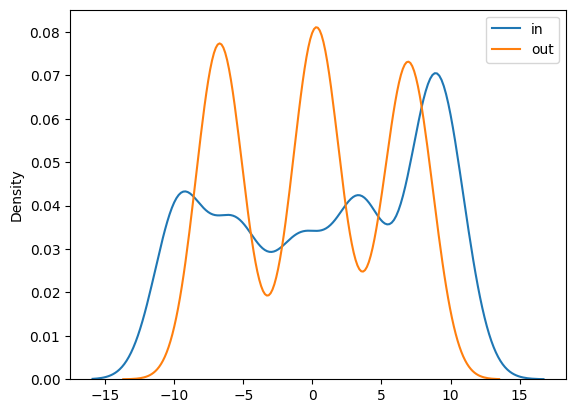

<ipython-input-25-1b8d046d8f18>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(in_samples, hist=False, kde_kws={"fill": False}, label='in')
<ipython-input-25-1b8d046d8f18>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(out_samples, hist=False, kde_kws={"fill": False}, lab

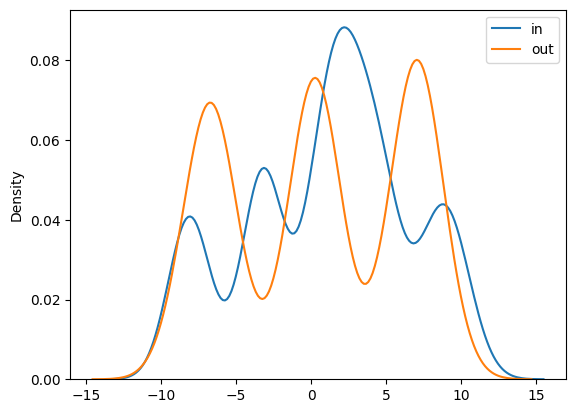

<ipython-input-25-1b8d046d8f18>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(in_samples, hist=False, kde_kws={"fill": False}, label='in')
<ipython-input-25-1b8d046d8f18>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(out_samples, hist=False, kde_kws={"fill": False}, lab

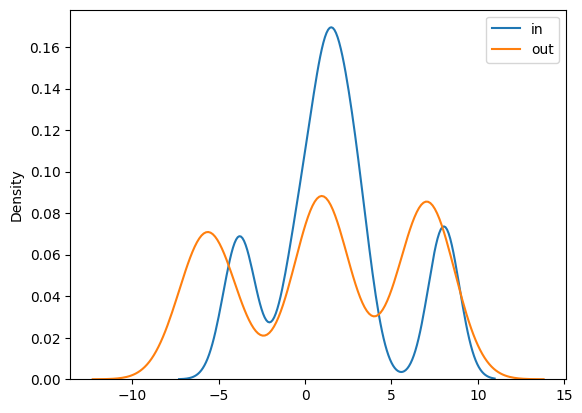

<ipython-input-25-1b8d046d8f18>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(in_samples, hist=False, kde_kws={"fill": False}, label='in')
<ipython-input-25-1b8d046d8f18>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(out_samples, hist=False, kde_kws={"fill": False}, lab

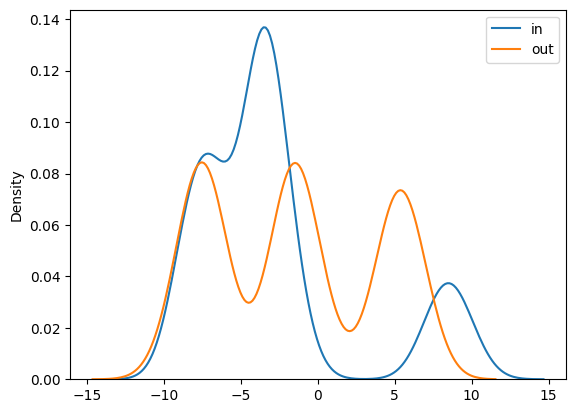

<ipython-input-25-1b8d046d8f18>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(in_samples, hist=False, kde_kws={"fill": False}, label='in')
<ipython-input-25-1b8d046d8f18>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(out_samples, hist=False, kde_kws={"fill": False}, lab

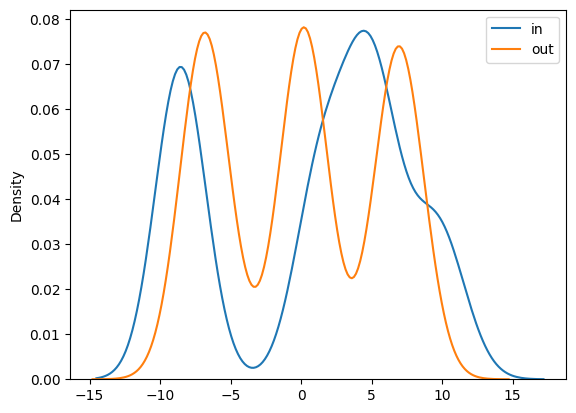

<ipython-input-25-1b8d046d8f18>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(in_samples, hist=False, kde_kws={"fill": False}, label='in')
<ipython-input-25-1b8d046d8f18>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(out_samples, hist=False, kde_kws={"fill": False}, lab

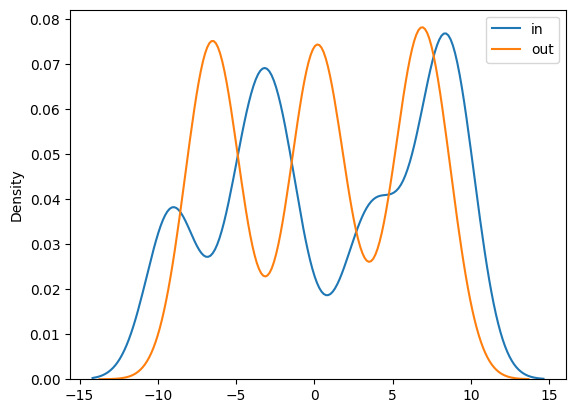

<ipython-input-25-1b8d046d8f18>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(in_samples, hist=False, kde_kws={"fill": False}, label='in')
<ipython-input-25-1b8d046d8f18>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(out_samples, hist=False, kde_kws={"fill": False}, lab

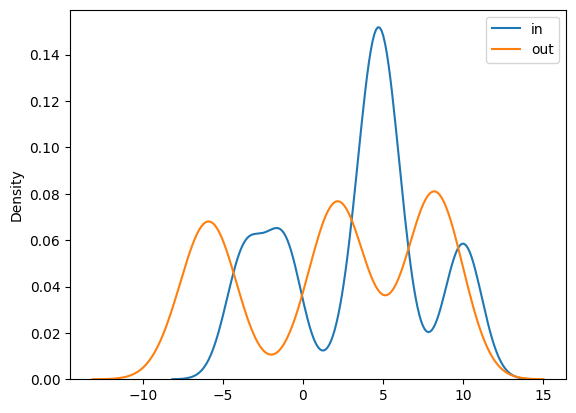

<ipython-input-25-1b8d046d8f18>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(in_samples, hist=False, kde_kws={"fill": False}, label='in')
<ipython-input-25-1b8d046d8f18>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(out_samples, hist=False, kde_kws={"fill": False}, lab

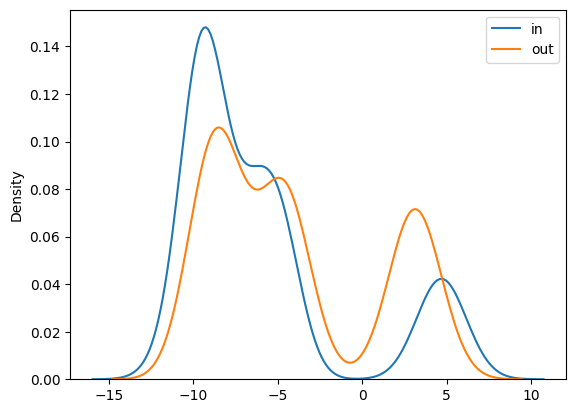

<ipython-input-25-1b8d046d8f18>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(in_samples, hist=False, kde_kws={"fill": False}, label='in')
<ipython-input-25-1b8d046d8f18>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(out_samples, hist=False, kde_kws={"fill": False}, lab

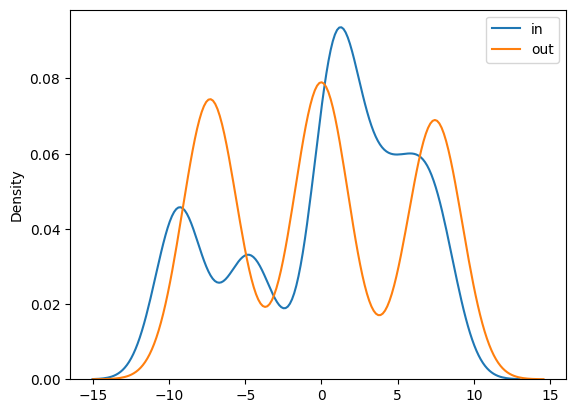

<ipython-input-25-1b8d046d8f18>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(in_samples, hist=False, kde_kws={"fill": False}, label='in')
<ipython-input-25-1b8d046d8f18>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(out_samples, hist=False, kde_kws={"fill": False}, lab

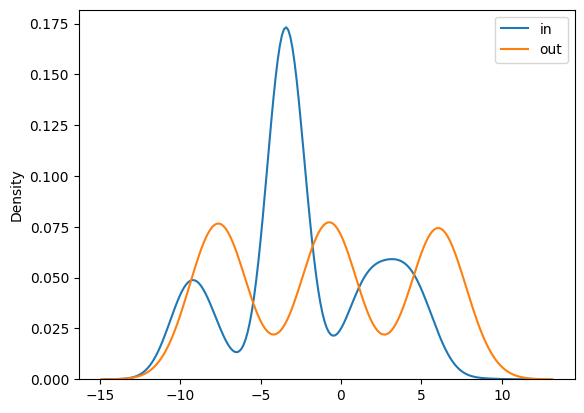

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)#, follow_batch=['x', 'edge_index','batch'])

for d in test_loader:
  in_pi = F.softmax(d.x[:M1,0],dim=0).detach().numpy()
  in_mu = d.x[:M1,1].detach().numpy()
  in_sigma = d.x[:M1,2].detach().numpy()
  out = model(d)
  out_pi = F.softmax(out[0,:,0],dim=0).detach().numpy()
  out_mu = out[0,:,1].detach().numpy()
  out_sigma = out[0,:,2].relu().detach().numpy()

  in_samples = []
  out_samples = []
  n = 1000 # nb of samples
  for i in range(n):  # iteratively draw samples
      Zin = np.random.choice(np.arange(M1), p=in_pi)
      Zout = np.random.choice(np.arange(M2), p=out_pi)
      in_samples.append(np.random.normal(in_mu[Zin], in_sigma[Zin], 1))
      out_samples.append(np.random.normal(out_mu[Zout], out_sigma[Zout], 1))
  sns.distplot(in_samples, hist=False, kde_kws={"fill": False}, label='in')
  sns.distplot(out_samples, hist=False, kde_kws={"fill": False}, label='out')
  plt.legend()
  plt.show()